# Skin Cancer BT

## Install MONAI, updata fastai, any other installs go here

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
pip install fastai==2.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 198.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.27
    Uninstalling fastcore-1.5.27:
      Successfully uninstalled fastcore-1.5.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Other installs here
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-j3e1kq4s/base-rbt_01a91c5eae0844f2b0fc7be3b65aec8f
  Running command git clone --filter=blob:none --quiet https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-j3e1kq4s/base-rbt_01a91c5eae0844f2b0fc7be3b65aec8f
  Resolved https://github.com/hamish-haggerty/base_rbt.git to commit d756d018ff8fd90403720c4de6a0732a0298f4fd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 727.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 5.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for base_rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=16049 sha256=207ab602430d31ef310418b8125215a66c411c4f4f68c520ee7b6c581ca7161e
  Stored in directory: /tmp/pip-ephem-wheel-

## Imports

In [5]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
#print_config()

In [6]:
import fastai
from fastai.vision.all import *
#Other imports here

from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

fastai.__version__

'2.7.10'

## Read image filenames from the dataset folders

In [7]:
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [8]:
#train
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

## Now get the training data and validation data etc

In [9]:
#Helper functions to extract class names from the filenames
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None

def label_func(x): return extract_text(x.as_posix())

#files names
fnames = get_image_files(train_dir)

#Extract training set
max_num =100 #maximum number of samples in each class
count_dict = {i:0 for i in class_names}
fnames_train = []
for i in fnames:
    #st=extract_text(i.as_posix())
    st=label_func(i)
    
    if count_dict[st]<max_num: #no more than 100 samples per category
        fnames_train.append(i)
        count_dict[st]+=1
                
#We further partition fnames_train into a tune-valiation set
count_dict2 = {i:0 for i in class_names}
fnames_tune = []
for i in fnames_train:
    st = label_func(i)
    if count_dict2[st] < 0.8*count_dict[st]:
        fnames_tune.append(i)
        count_dict2[st]+=1
        
def get_difference(x1, x2):
    return list(set(x1) - set(x2))

fnames_valid = get_difference(fnames_train,fnames_tune)

fnames_test = get_difference(fnames,fnames_train) + get_image_files(test_dir)

#sanity check
def display_dict(_fnames):
    
    _labels = [label_func(i) for i in _fnames]
    tem_dict = {i:_labels.count(i) for i in _labels}
    return tem_dict

tem_dict = display_dict(fnames)
print(f'The "original" training set: \n {tem_dict}\n')

tem_dict = display_dict(fnames_train)
print(f'Training set: used to train BT etc i.e. viewed as unlabelled \n {tem_dict}\n')

print('The training set is partitioned into tune-valid sets, with ~ 80-20 split\n')

tem_dict = display_dict(fnames_tune)
print(f'Tune set: used to train classifiers on representations \n {tem_dict}\n')

tem_dict = display_dict(fnames_valid)
print(f'Valid set: used to validate the classifiers trained above \n {tem_dict}\n')

tem_dict = display_dict(fnames_test)
print(f'Test set: only examine at the very end {tem_dict}\n')


The "original" training set: 
 {'pigmented benign keratosis': 462, 'melanoma': 438, 'vascular lesion': 139, 'actinic keratosis': 114, 'squamous cell carcinoma': 181, 'basal cell carcinoma': 376, 'seborrheic keratosis': 77, 'dermatofibroma': 95, 'nevus': 357}

Training set: used to train BT etc i.e. viewed as unlabelled 
 {'pigmented benign keratosis': 100, 'melanoma': 100, 'vascular lesion': 100, 'actinic keratosis': 100, 'squamous cell carcinoma': 100, 'basal cell carcinoma': 100, 'seborrheic keratosis': 77, 'dermatofibroma': 95, 'nevus': 100}

The training set is partitioned into tune-valid sets, with ~ 80-20 split

Tune set: used to train classifiers on representations 
 {'pigmented benign keratosis': 80, 'melanoma': 80, 'vascular lesion': 80, 'actinic keratosis': 80, 'squamous cell carcinoma': 80, 'basal cell carcinoma': 80, 'seborrheic keratosis': 62, 'dermatofibroma': 76, 'nevus': 80}

Valid set: used to validate the classifiers trained above 
 {'basal cell carcinoma': 20, 'sebor

## Now get the training dataloader and view the data

In [10]:
#get data

#TODO: We can probably avoid these dataloaders?

device ='cuda' if torch.cuda.is_available() else 'cpu'

bs=64
size=128
n_in=3
numfit=200
ps=1024

item_tfms = [Resize(size)]

dls_train  = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                      bs=bs,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
x,y = dls_train.one_batch()

dls_tune = ImageDataLoaders.from_path_func(train_dir, fnames_tune, label_func,
                                      bs=len(fnames_valid),
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
xtune,ytune = dls_tune.one_batch()

dls_valid  = ImageDataLoaders.from_path_func(train_dir, fnames_valid, label_func,
                                      bs=len(fnames_valid),
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
xval,yval = dls_valid.one_batch()

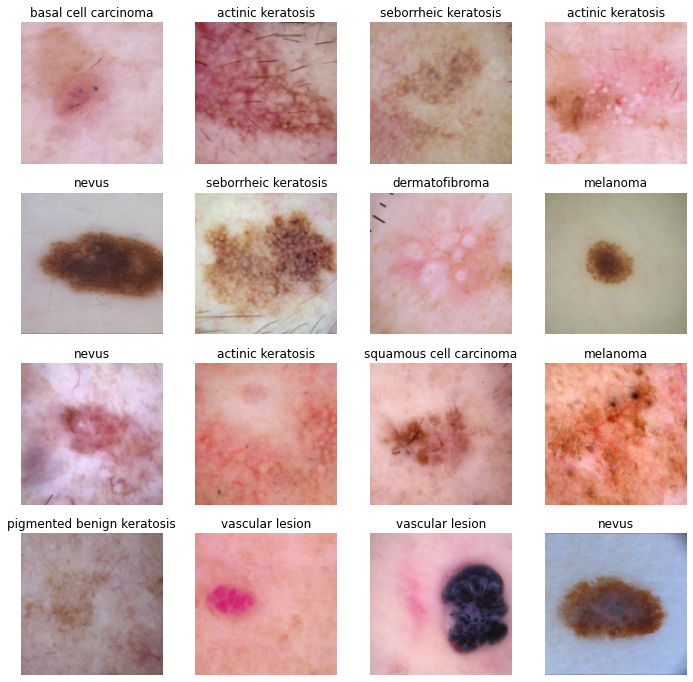

In [11]:
dls_train.show_batch(max_n=16)

## BT stuff now!

In [12]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

In [13]:
#Compute the mean and standard deviation of the dataset: 
def compute_mean_std(dls):
    # Initialize variables to store the sum and sum of squares of the data
    channel_sum = [0, 0, 0]
    channel_sum_squares = [0, 0, 0]

    # Iterate over the data in the dataloader
    for data,y in dls:
        
        batch_size, _, height, width = data.shape

        # Compute the sum and sum of squares of the data for each channel
        for channel in range(3):
            channel_sum[channel] += data[:, channel, :, :].sum()
            channel_sum_squares[channel] += (data[:, channel, :, :] ** 2).sum()

    # Calculate the number of elements in the data
    num_elements = batch_size * height * width * len(dls)

    # Calculate the mean and standard deviation for each channel
    means = [(channel_sum[i] / num_elements).item() for i in range(3)]
    stddevs = [(((channel_sum_squares[i] / num_elements) - means[i]**2)**0.5).item() for i in range(3)]

    return means, stddevs

means, stddevs = compute_mean_std(dls_train.train)

isic_stats_128 = means,stddevs #when shape is 128
print("Means:", means)
print("Standard deviations:", stddevs)

#Normalize.from_stats(mean=means,std=stddevs)

Means: [0.7620632648468018, 0.5874651670455933, 0.5922873020172119]
Standard deviations: [0.12114911526441574, 0.1405756175518036, 0.15672306716442108]


In [18]:
isic_stats_128

([0.7609121799468994, 0.5869480967521667, 0.5924641489982605],
 [0.12186530977487564, 0.14097826182842255, 0.15697918832302094])

Ok, there is now a question of which augmentations to use...

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.25, 's': 11, 'sig': None, 'blur_r': (0.5, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.7621]],

         [[0.5875]],

         [[0.5923]]]], device='cuda:0'), 'std': tensor([[[[0.1211]],

         [[0.1406]],

         [[0.1567]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.25, 's': 11, 'sig': None, 'blur_r': (0.5, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor

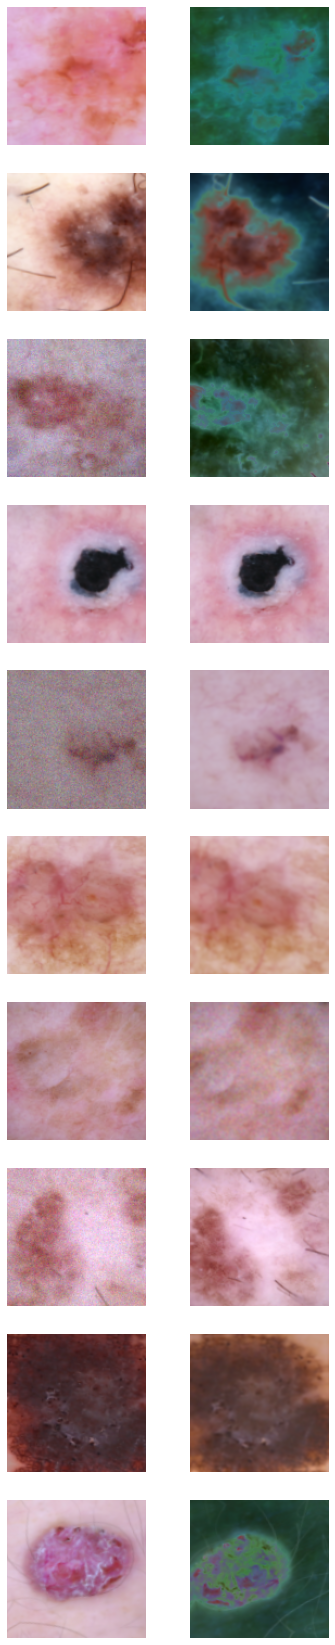

In [14]:
#Ok, there is now a huge question of which augmentations to apply!!!
aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=(0.5,2),
                    rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=20,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.75,noise_p=0.25, jitter_p=0.25, bw_p=0.05, blur_p=0.25,sol_p=0.05, #prob of performing aug
                    same_on_batch=False,stats=isic_stats_128, cuda=(device=='cuda'))

aug_pipelines = [aug_pipelines_1,aug_pipelines_1]

#View the augmentations the "usual way"
show_bt_batch(dls=dls_train,n_in=3,aug=aug_pipelines,n=10,print_augs=True)

## Train BT

In [35]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
learn.fit(300)

epoch,train_loss,valid_loss,time
0,225.541458,None,00:25
1,194.058945,None,00:23
2,173.335037,None,00:23
3,160.280762,None,00:25
4,148.725510,None,00:23
5,142.539536,None,00:24
6,136.316849,None,00:23
7,130.170151,None,00:24
8,126.806885,None,00:23
9,123.435776,None,00:24


In [36]:
#clone model 

import pickle
copyed_model = pickle.loads(pickle.dumps(model))

In [ ]:
#17.4250

## Linear evaluation / fine tuning:


Pipeline: RandomResizedCrop
Pipeline: 


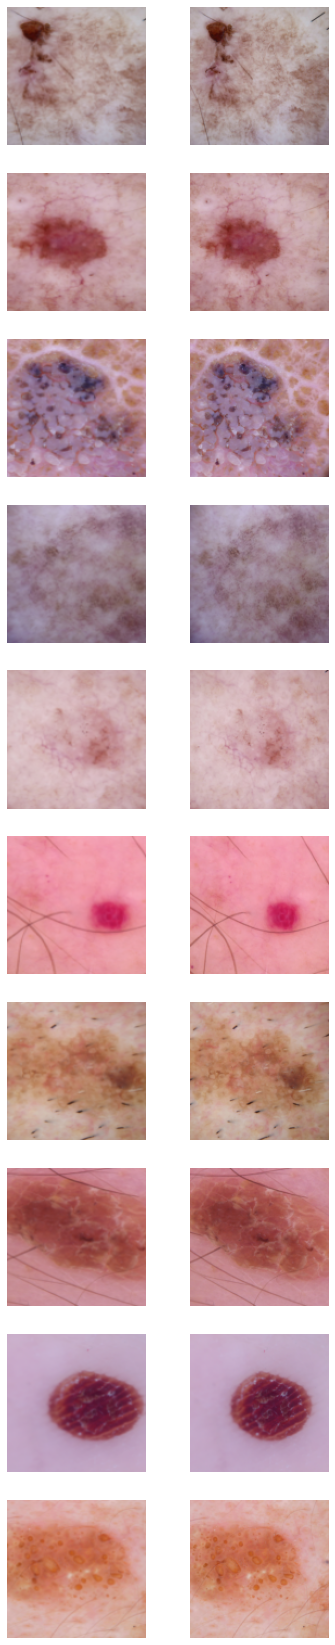

In [37]:
#Something weird goes on with normalization...

numfit=200
n_in=3

criterion = nn.CrossEntropyLoss()

isic_stats_128 = ([0.7609121799468994, 0.5869480967521667, 0.5924641489982605],[0.12186530977487564, 0.14097826182842255, 0.15697918832302094])
#stats = cifar_stats

aug_pipelines_tune=[get_linear_batch_augs(size=size,stats=None,resize=True,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3))]

show_linear_batch(dls=dls_tune,n_in=n_in,n=10,aug=aug_pipelines_tune,print_augs=True)

In [44]:
#fine tune standard xresnet (pre-trained!) on the raw pixels
def fit_model(x,y,model):
    
    opt = Adam(model.parameters(),lr=0.001)
 
    for epoch in range(numfit):

        x = aug_pipelines_tune[0](x) #augmentation
        out = model(x)
        loss = criterion(out,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        print(loss)
        
    return model

@torch.no_grad()
def predict_model(xval,yval,model):
    
    #need accuracy, also so F1 score and whatever other stuff we need...
    model.eval()
    
    test_eq(model.encoder.training,False)
    
    N=xval.shape[0]
    ypred=model(xval)
    correct = (torch.argmax(ypred,dim=1) == yval).type(torch.FloatTensor)
    num_correct = correct.sum()
    accuracy = num_correct/N
    return accuracy.item()
    
if __name__ == '__main__':
    
    encoder = pickle.loads(pickle.dumps(fastai_encoder)) #copy
    
    #encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    model = LinearModel(encoder=encoder,indim=1024,outdim=9).cuda() #composition of encoder and linear head
    model = fit_model(xtune,ytune,model)

    acc = predict_model(xval,yval,model)
    
    print(f'Accuracy is {acc}') #Accuracy is 0.32758620381355286

TensorCategory(2.2008, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.2547, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.1274, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.0765, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.0554, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.9918, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.9023, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.8265, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.7844, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.7287, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.6858, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.6524, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.6251, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.6258, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.5985, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCate

In [ ]:
#Baseline accuracy is: 0.235,0.1896,0.2643,0.172,0.24137
#BT accuracy is (Fine tune): 0.30,0.2126,0.28160,0.206896,0.304597

#So BT is slightly better already, on the first try. Cool. Performance of course is bad...

In [ ]:
from statistics import mean

mean([0.235,0.1896,0.2643,0.172,0.24137])

mean([0.30,0.2126,0.28160,0.206896,0.304597])

## Summary:

Everything was done "as is"

Encouraging results: BT is slightly better, as we hoped. 



Ok, what should be my plan of attack over this next ~ 4 hours?

I don't care how tired you are. We are going to get somewhere:

- Definitely tinker a little. Depending on results, mess around with the augmentations. Purely exploratory. That is fine. 
- What I really need to do: Look into more general things (not programming). i.e. a few that come to mind:
    1) Can I actually use this dataset!!! i.e. how to cite it etc
    2) Read about ICIC. Collect sources. That kind of thing. 
    
Ok, that's enough to get started.


Ok, need to think about project more:

- PCA seems not to work, annoyingly. 

Seems like it would be good to have some other baseline re "pretraining" (on the unlabelled data that we have access to. Something kind of like PCA. If there is such a thing?

- Or maybe a standard autoencoder?
- Actually, one interesting thing to compare could be a "redundancy reduction" autoencoder. This is natural to compare of course. We can use this to pretrain. 